In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statistics
from sklearn.model_selection import train_test_split

# Functions/Methods

In [11]:
def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

#check cointegration status
def cointegration(data1,data2):
    
    #train test split 
    df1,test1,df2,test2=train_test_split(data1,data2,test_size=0.7,shuffle=False)
    
    train=pd.DataFrame()
    train['asset1']=df1['Close']
    train['asset2']=df2['Close']
    
    #this is the part where we test the cointegration
    #in this case, i use Engle-Granger two-step method
    #which is invented by the mentor of my mentor!!!
    #generally people use Johanssen test to check the cointegration status
    #the first step for EG is to run a linear regression on both variables
    #next, we do OLS and obtain the residual
    #after that we run unit root test to check the existence of cointegration
    #if it is stationary, we can determine its a drunk man with a dog
    #the first step would be adding a constant vector to asset1
    
    x=sm.add_constant(train['asset1'])
    y=train['asset2']
    model=sm.OLS(y,x).fit()
    
    #print(model.summary())
    #print('\n',sm.tsa.stattools.adfuller(model.resid))

    #this phrase is how we set the trigger conditions
    #first we normalize the residual
    #we would get a vector that follows standard normal distribution
    #generally speaking, most tests use one sigma level as the threshold
    #two sigma level reaches 95% which is relatively difficult to trigger
    #after normalization, we should obtain a white noise follows N(0,1)
    #we set +-1 as the threshold
    #eventually we visualize the result
    
    signals=pd.DataFrame()
    signals['asset1']=test1['Close']
    signals['asset2']=test2['Close']
    
    signals['fitted']=np.mat(sm.add_constant(signals['asset2']))*np.mat(model.params).reshape(2,1)
    signals['residual']=signals['asset1']-signals['fitted']
    signals['z']=(signals['residual']-np.mean(signals['residual']))/np.std(signals['residual'])
    
    #use z*0 to get panda series instead of an integer result
    signals['z upper limit']=signals['z']*0+np.mean(signals['z'])+np.std(signals['z'])
    signals['z lower limit']=signals['z']*0+np.mean(signals['z'])-np.std(signals['z'])
    
    return signals

#the signal generation process is very straight forward
#if the normalized residual gets above or below threshold
#we long the bearish one and short the bullish one, vice versa
#i only need to generate trading signal of one asset
#the other one should be the opposite direction
def signal_generation(df1,df2,method):
    
    signals=method(df1,df2)

    signals['signals1']=0
    
    #as z statistics cannot exceed both upper and lower bounds at the same time
    #this line holds
    signals['signals1']=np.select([signals['z']>signals['z upper limit'], \
                                   signals['z']<signals['z lower limit']], \
                                   [-1,1],default=0)
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()
    
    #fix initial positions issue
    if signals['signals1'].iloc[0]!=0:
        signals['positions1'].iloc[0]=signals['signals1'].iloc[0]
        signals['positions2'].iloc[0]=signals['signals2'].iloc[0]        
    
    return signals


#position visualization
def plot(new,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(10,5))#10,5 --15,6
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #plot two different assets
    l1,=bx.plot(new.index,new['asset1'],c='#4abdac')
    l2,=bx2.plot(new.index,new['asset2'],c='#907163')

    u1,=bx.plot(new.loc[new['positions1']==1].index,new['asset1'][new['positions1']==1],lw=0,marker='^',markersize=8,c='g',alpha=0.7)
    d1,=bx.plot(new.loc[new['positions1']==-1].index,new['asset1'][new['positions1']==-1],lw=0,marker='v',markersize=8,c='r',alpha=0.7)
    u2,=bx2.plot(new.loc[new['positions2']==1].index,new['asset2'][new['positions2']==1],lw=0,marker=2,markersize=9,c='g',alpha=0.9,markeredgewidth=3)
    d2,=bx2.plot(new.loc[new['positions2']==-1].index,new['asset2'][new['positions2']==-1],lw=0,marker=3,markersize=9,c='r',alpha=0.9,markeredgewidth=3)

    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([l1,l2,u1,d1,u2,d2],
               [ticker1,ticker2,
               'LONG {}'.format(ticker1),
               'SHORT {}'.format(ticker1),
               'LONG {}'.format(ticker2),
               'SHORT {}'.format(ticker2)],
               loc=8)

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
  

#visualize overall portfolio performance
def portfolio(df1):

    #initial capital to calculate the actual pnl
    capital0=20000

    #shares to buy of each position
    positions1=capital0//max(df1['asset1'])
    positions2=capital0//max(df1['asset2'])

    #cumsum1 column is created to check the holding of the position
    df1['cumsum1']=df1['positions1'].cumsum()

    #since there are two assets, we calculate each asset separately
    #in the end we aggregate them into one portfolio
    portfolio=pd.DataFrame()
    portfolio['asset1']=df1['asset1']
    portfolio['holdings1']=df1['cumsum1']*df1['asset1']*positions1
    portfolio['cash1']=capital0-(df1['positions1']*df1['asset1']*positions1).cumsum()
    portfolio['total asset1']=portfolio['holdings1']+portfolio['cash1']
    portfolio['return1']=portfolio['total asset1'].pct_change()
    portfolio['positions1']=df1['positions1']
    
    df1['cumsum2']=df1['positions2'].cumsum()
    portfolio['asset2']=df1['asset2']
    portfolio['holdings2']=df1['cumsum2']*df1['asset2']*positions2
    portfolio['cash2']=capital0-(df1['positions2']*df1['asset2']*positions2).cumsum()
    portfolio['total asset2']=portfolio['holdings2']+portfolio['cash2']
    portfolio['return2']=portfolio['total asset2'].pct_change()
    portfolio['positions2']=df1['positions2']
 
    portfolio['z']=df1['z']
    portfolio['total asset']=portfolio['total asset1']+portfolio['total asset2']
    portfolio['z upper limit']=df1['z upper limit']
    portfolio['z lower limit']=df1['z lower limit']
    
    #plotting the asset value change of the portfolio
    fig=plt.figure(figsize=(10,5))#10,5 --15,6
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
 
    l1,=ax.plot(portfolio['total asset'],c='#46344e')
    l2,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
 
    b=ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                    portfolio['z lower limit'], \
                    alpha=0.2,color='#ffb48f')
     
    #due to the opposite direction of trade for 2 assets
    #we will not plot positions on asset performance
    
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    
    plt.legend([l2,b,l1],['Z Statistics',
                          'Z Statistics +-1 Sigma',
                          'Total Asset Performance'],loc='best')

    plt.grid(True)   
    plt.title('Total Asset')
    plt.show()

    return portfolio

# Fixed tests with csv

In [12]:
y_symbol = 'FLRY3'
x_symbol = 'LREN3'

data = pd.read_csv('datasets/data.csv')

y = pd.DataFrame(pd.read_csv('datasets/data.csv')[y_symbol], columns=[y_symbol])
x = pd.DataFrame(pd.read_csv('datasets/data.csv')[x_symbol], columns=[x_symbol])

period = 160
y = y.iloc[(data.shape[0]-period):]
x = x.iloc[(data.shape[0]-period):]

y.columns = ['Close']
x.columns = ['Close']

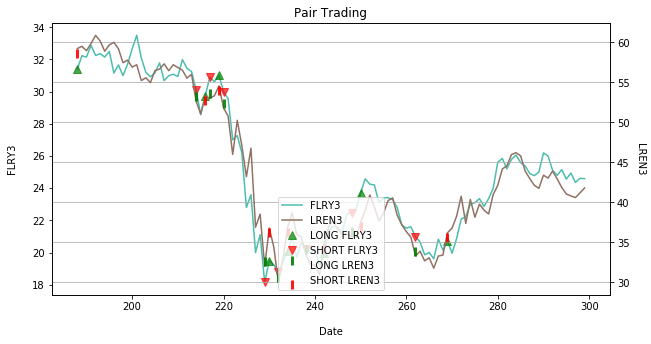

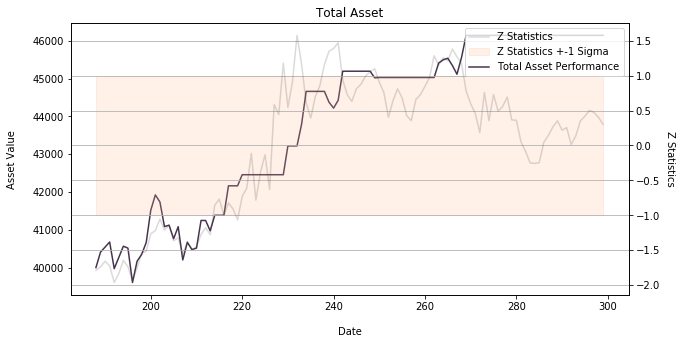

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
188,31.39,18739.83,1260.17,20000.00,NaN,1.0,59.22,-19424.16,39424.16,20000.00,NaN,-1.0,-1.787639,40000.00,1.0,-1.0
189,32.23,19241.31,1260.17,20501.48,0.025074,0.0,59.50,-19516.00,39424.16,19908.16,-0.004592,0.0,-1.738783,40409.64,1.0,-1.0
190,32.15,19193.55,1260.17,20453.72,-0.002330,0.0,58.95,-19335.60,39424.16,20088.56,0.009062,0.0,-1.657666,40542.28,1.0,-1.0
191,32.87,19623.39,1260.17,20883.56,0.021015,0.0,59.85,-19630.80,39424.16,19793.36,-0.014695,0.0,-1.723958,40676.92,1.0,-1.0
192,32.25,19253.25,1260.17,20513.42,-0.017724,0.0,60.87,-19965.36,39424.16,19458.80,-0.016903,0.0,-1.961059,39972.22,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24.56,0.00,17271.71,17271.71,0.000000,0.0,41.05,0.00,28872.40,28872.40,0.000000,0.0,0.419903,46144.11,1.0,-1.0
296,24.94,0.00,17271.71,17271.71,0.000000,0.0,40.81,0.00,28872.40,28872.40,0.000000,0.0,0.502098,46144.11,1.0,-1.0
297,24.36,0.00,17271.71,17271.71,0.000000,0.0,40.60,0.00,28872.40,28872.40,0.000000,0.0,0.471096,46144.11,1.0,-1.0
298,24.61,0.00,17271.71,17271.71,0.000000,0.0,41.20,0.00,28872.40,28872.40,0.000000,0.0,0.400959,46144.11,1.0,-1.0


In [13]:
signals=signal_generation(y, x, cointegration)
plot(signals,y_symbol, x_symbol)
portfolio(signals)

In [14]:
signals

,asset1,asset2,fitted,residual,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2,cumsum1,cumsum2
188,31.39,59.22,97.882363,-66.492363,-1.787639,1.0,-1.0,1,1.0,-1,-1.0,1.0,-1.0
189,32.23,59.50,98.289215,-66.059215,-1.738783,1.0,-1.0,1,0.0,-1,0.0,1.0,-1.0
190,32.15,58.95,97.490042,-65.340042,-1.657666,1.0,-1.0,1,0.0,-1,0.0,1.0,-1.0
191,32.87,59.85,98.797780,-65.927780,-1.723958,1.0,-1.0,1,0.0,-1,0.0,1.0,-1.0
192,32.25,60.87,100.279884,-68.029884,-1.961059,1.0,-1.0,1,0.0,-1,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24.56,41.05,71.480575,-46.920575,0.419903,1.0,-1.0,0,0.0,0,0.0,0.0,0.0
296,24.94,40.81,71.131844,-46.191844,0.502098,1.0,-1.0,0,0.0,0,0.0,0.0,0.0
297,24.36,40.60,70.826705,-46.466705,0.471096,1.0,-1.0,0,0.0,0,0.0,0.0,0.0
298,24.61,41.20,71.698531,-47.088531,0.400959,1.0,-1.0,0,0.0,0,0.0,0.0,0.0


# Gráfico dos Resíduos em torno da média

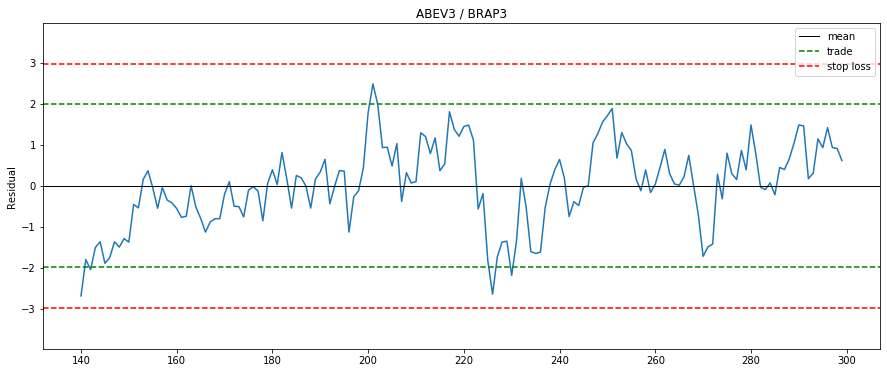

In [15]:
model=model_ols(y['Close'], x['Close'])
std = statistics.stdev(model.resid)
gap=0.5

entry_threshold = 2 # entrada em 2 desvio padrão
exit_threshold =entry_threshold-gap
stop_loss_threshold = 3 # stop loss em 3 desvio padrão

plt.figure(figsize=(15,6))
plt.plot(model.resid)
plt.ylabel('Residual')
plt.title(y_csv.replace('.csv', '') + ' / ' + x_csv.replace('.csv', ''))

plt.axhline(0, linewidth=1,color='black',label='mean') # Add the mean of residual
plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
plt.axhline(-entry_threshold*std, color='green', linestyle='--')
#plt.axhline(std*exit_threshold, color='blue', linestyle='--',label='saída')
#plt.axhline(-std*exit_threshold, color='blue', linestyle='--')
plt.axhline(stop_loss_threshold*std, color='red', linestyle='--',label='stop loss')
plt.axhline(-stop_loss_threshold*std, color='red', linestyle='--')

plt.ylim(-std*stop_loss_threshold-1,std*stop_loss_threshold+1)
plt.legend()
plt.show()

In [6]:
#print(model.summary())